In [1]:
using Plots
using StatsPlots
using JLD2
using MPSTime
using StatsBase
#using Measures
using LaTeXStrings
#using Pickle
using Plots.PlotMeasures

In [37]:
function hm_convert(xs,ys,zs, annotations=false; verbosity=0)
    xs_full = range(extrema(xs)...)
    ys_full = range(extrema(ys)...)

    zs_full = Matrix{Union{Float64,Missing}}(missing, length(ys_full), length(xs_full))

    scale = ones(Int, size(zs_full)...)
    dupes = 0
    n = length(zs)
    anns = Dict{Tuple, Any}()
    for (i, z) in enumerate(zs)
        xi = findfirst(==(xs[i]), xs_full)
        yi = findfirst(==(ys[i]), ys_full)

        if ismissing(zs_full[yi, xi])
            zs_full[yi, xi] = z

        else
            zs_full[yi, xi] += z
            scale[yi, xi] += 1
            dupes += 1
        end
        anns[xs[i], ys[i]] =  text("$(scale[yi,xi])", halign=:center, valign=:center, color=:white)

    end
    verbosity >= 1 && println("n=$n, Duplicates=$dupes")

    if annotations
        xs_ann, ys_ann, ts_ann = [],[],[]
        for ((x,y), text) in pairs(anns)
            push!(xs_ann, x)
            push!(ys_ann, y)
            push!(ts_ann, text)
        end
        return xs_full, ys_full, (zs_full ./= scale), (xs_ann, ys_ann, ts_ann)

    else

        return xs_full, ys_full, (zs_full ./= scale)
    end
end

function loss_opts(res; verbosity=0)
    losses = getindex.(res,"loss") .|> mean
    opts = getindex.(res, "opts")

    ds = getproperty.(opts, :d)
    chis = getproperty.(opts, :chi_max)
    etas = getproperty.(opts, :eta)
    nsw = getproperty.(opts, :nsweeps)
    return losses, ds, chis, nsw, etas
end

function get_hm_vals(res, annotations=true; verbosity=0)
    losses, ds, chis, nsw, etas = loss_opts(res; verbosity=verbosity)
    return hm_convert(chis, ds, losses, annotations; verbosity=verbosity)
end

function map_dupes(res; verbosity=0)
    losses, ds, chis, nsw, etas = loss_opts(res; verbosity=verbosity)
    pairs = zip(ds, chis, nsw) |> collect
    return countmap(pairs)
end

function unroll_cache(res)
    res2 = []

    for r in res
        cache = r["cache"]
        for (k,v) in pairs(cache)
            chi,d,eta = k
            push!(res2, Dict(
                "loss" => v, 
                "opts" => MPSTime._set_options(r["opts"], chi_max=chi, d=d, eta=eta)
            ))
        end
    end
    return res2
end

unroll_cache (generic function with 1 method)

# ECG

In [2]:
@load "ECG200/ECG_classification_PSwarm.jld2" res
res_ECG = [res[i] for i in 1:30]

30-element Vector{Dict{String, Any}}:
 Dict("eval_windows" => nothing, "cache" => Dict((32, 3, 0.00767314272106322) => 0.14, (33, 2, 0.012950221377932945) => 0.16, (32, 3, 0.005566750599102161) => 0.11000000000000001, (32, 3, 0.007552675158685203) => 0.08, (33, 3, 0.001) => 0.12999999999999998, (23, 5, 0.001) => 0.18, (33, 3, 0.013308330024741223) => 0.14, (32, 3, 0.17615473450278438) => 0.11000000000000001, (32, 3, 0.007535115920225977) => 0.12, (36, 3, 0.009426866539863426) => 0.10999999999999999…), "time" => 4493.82719707489, "tuning_pms" => nothing, "objective" => "MisclassificationRate()", "train_inds" => [48, 159, 44, 58, 19, 182, 158, 115, 3, 186  …  80, 34, 75, 141, 61, 29, 72, 11, 40, 90], "optimiser" => "ParticleSwarm{Vector{Any}, Vector{Any}}(Any[], Any[], 0)", "loss" => [0.12], "eval_pms" => nothing, "opts" => MPSOptions(-5, 10, 32, 0.007552675158685203, 3, :Legendre_No_Norm, false, 2, 1.0e-10, 1, Float64, :KLD, :TSGO, false, (false, true), false, false, false, true, false,

In [14]:
optss = getindex.(res_ECG, "opts")
chi = getfield.(optss,:chi_max) |> median
d = getfield.(optss,:d) |> median

print("max_d: $d, max_chi: $chi")

max_d: 5.0, max_chi: 30.0

In [ ]:
g

In [29]:
losses = [r["loss"][1] for r in res_ECG];

In [27]:
1 - mean(losses)

0.8626666666666667

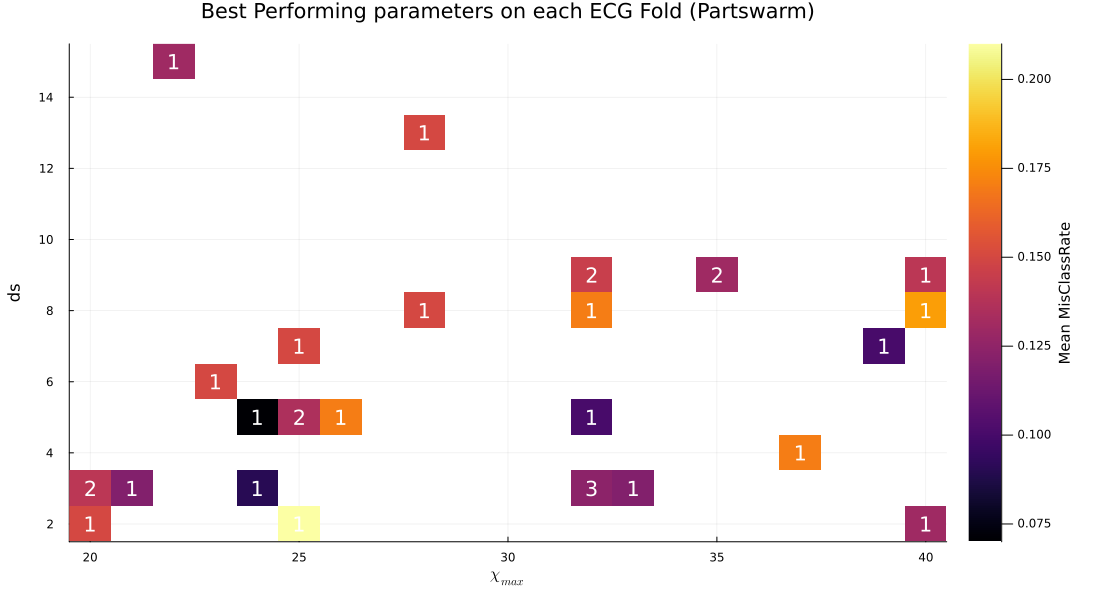

In [40]:
ds, chis, losses, anns = get_hm_vals(res_ECG)
hm =heatmap(ds, chis, losses,
    size=(1100,600),
    colorbar_title="Mean MisClassRate",
    bottom_margin=5mm, 
    left_margin=5mm, 
    right_margin=5mm,
    top_margin=5mm
)
annotate!(anns...)
xlabel!(L"$\chi_{\rm{max}}$")
ylabel!("ds")
title!("Best Performing parameters on each ECG Fold (Partswarm)")
plot(hm)
# savefig("Class_Pswarm.png")

In [ ]:
ds, chis, losses, anns = get_hm_vals(unroll_cache(res_ECG))
hm =heatmap(ds, chis, losses,
    size=(1100,600),
    colorbar_title="Mean MisClassRate",
    bottom_margin=5mm, 
    left_margin=5mm, 
    right_margin=5mm,
    top_margin=5mm
)
annotate!(anns...)
xlabel!(L"$\chi_{\rm{max}}$")
ylabel!("ds")
title!("Best Performing parameters on each ECG Fold (Partswarm)")
plot(hm)
# savefig("Class_Pswarm_full.png")

"/home/noodles/.julia/dev/MPSTime.jl/Folds/Class_Pswarm_full.png"

Dict{Tuple{Int64, Int64, Float64}, Float64} with 253 entries:
  (32, 3, 0.00767314) => 0.14
  (33, 2, 0.0129502)  => 0.16
  (32, 3, 0.00556675) => 0.11
  (32, 3, 0.00755268) => 0.08
  (33, 3, 0.001)      => 0.13
  (23, 5, 0.001)      => 0.18
  (33, 3, 0.0133083)  => 0.14
  (32, 3, 0.176155)   => 0.11
  (32, 3, 0.00753512) => 0.12
  (36, 3, 0.00942687) => 0.11
  (32, 3, 0.0125306)  => 0.11
  (32, 3, 0.0122351)  => 0.12
  (32, 3, 0.00671992) => 0.13
  (32, 3, 0.00722647) => 0.14
  (32, 4, 0.00930435) => 0.17
  (32, 3, 0.00891583) => 0.15
  (32, 3, 0.0130365)  => 0.15
  (32, 3, 0.00753844) => 0.12
  (32, 3, 0.00641137) => 0.15
  ⋮                   => ⋮